In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from IPython.display import display_html

# I use this function to help me visualize things side by side. Helps me from creating really lengthy notebooks.

def display_side_by_side(*args):
    html_str=''
    for table in args:
        html_str+=table.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
from warnings import filterwarnings

filterwarnings('ignore') #for the sake of posting online

In [2]:
#Importing the relevant packages

SEED = 99
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE

In [3]:
# Redefine functions


def pull_month(m):
    return int(m[5:7])


def process(feat_df_path, 
            labels_df_path = None,
            features_iq = None,
            features_sj = None,
            interpolate_method='linear',
            drop_date=True,
            standardize = True,
            remove_outliers=False,
            pull_months = True):
    
    # load data and set index
        df = pd.read_csv(feat_df_path, index_col=[0, 1, 2])
    
    # create months and drop week_start_date
        months = df.week_start_date.apply(pull_month)
    
        if drop_date:
            df = df.drop(['week_start_date'], axis=1)
        
    # fill missing values
        #df = df.fillna(method=fill_method)
        if interpolate_method:
            df = df.interpolate('linear')
    
        #if remove_outliers:
        #    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

        if standardize:
            scaler = StandardScaler()
            df[df.columns] = scaler.fit_transform(df)
    
    
    # join labels df
        if labels_df_path:
            labels = pd.read_csv(labels_df_path, index_col=[0, 1, 2])
            df = df.join(labels)
    
    # split sj and iq
        iq_df = df.loc['iq']
        sj_df = df.loc['sj']
    
        if features_iq != None:
            iq_df = iq_df[features_iq]
        if features_sj != None:
            sj_df = sj_df[features_sj]
        
    # Month one hot features
        if pull_months:
            month_features = pd.get_dummies(months, prefix='m_')
            iq_df = iq_df.join(month_features.loc['iq'])
            sj_df = sj_df.join(month_features.loc['sj'])
        
        return iq_df, sj_df



In [4]:
#Let's also create a function to help quickly split datasets

def split_sets(iq_dataset, sj_dataset, shuffle = True, time_shift=0, test_size = 0.2):
    
    X_iq = iq_dataset.drop(['total_cases'], axis=1)
    y_iq = iq_dataset['total_cases']

    X_sj = sj_dataset.drop(['total_cases'], axis=1)
    y_sj = sj_dataset['total_cases']
    
    if time_shift:
        y_sj = y_sj.shift(time_shift, axis=0).dropna()
        y_iq = y_iq.shift(time_shift, axis=0).dropna()
        X_sj = X_sj[:-time_shift]
        X_iq = X_iq[:-time_shift]
    
    X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(X_iq, y_iq, shuffle = shuffle, 
                                                                    test_size=test_size, random_state=SEED)

    X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(X_sj, y_sj, shuffle = shuffle,
                                                                    test_size=test_size, random_state=SEED)
    
    
    return X_train_iq, X_test_iq, y_train_iq, y_test_iq, X_train_sj, X_test_sj, y_train_sj, y_test_sj

## Part 6: Feature Engineering
Now that we have our benchmark. Let's see take a deep dive into these features. First, let's see how the features relate to the total cases seen in a given city.

In [5]:
#Before we get going let's reload the data, this time without the months pulled out. This will make things confusing in this next
#part, wee will add them back later.

#load data, preprocess, and split between two cities

iq_train, sj_train = process(feat_df_path = 'dengue_features_train.csv',
                             labels_df_path='dengue_labels_train.csv',
                             pull_months=False)

In [6]:
iq_corr = iq_train.corr(method ='pearson')
sj_corr = sj_train.corr(method ='pearson')

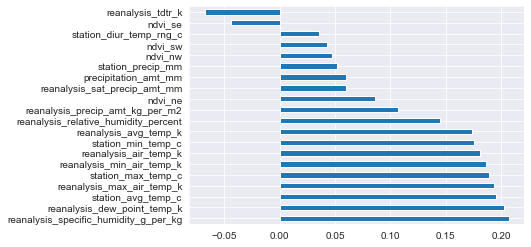

In [7]:
sns.set_style('darkgrid')
sj_corr = sj_corr.total_cases.drop('total_cases').sort_values(ascending=False)
sj_corr.plot.barh()

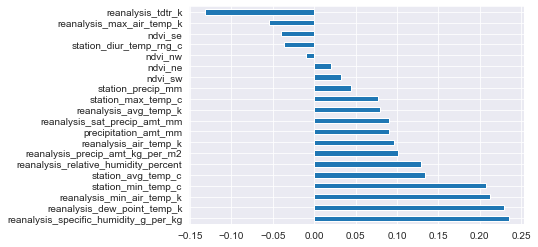

In [8]:
iq_corr = iq_corr.total_cases.drop('total_cases').sort_values(ascending=False)
iq_corr.plot.barh()

In [9]:
iq_corr = iq_corr.loc[abs(iq_corr >=0.10)]
sj_corr = sj_corr.loc[abs(sj_corr >=0.10)]

iq_corr = iq_corr.reset_index()
sj_corr = sj_corr.reset_index()

features_iq = iq_corr['index']
features_sj = sj_corr['index']

iq_train_reduced = iq_train[features_iq]
sj_train_reduced = sj_train[features_sj]

In [10]:
print("The San Juan Dataframe's dimensionality reduced from {} to {}.".format(sj_train.shape[1], sj_train_reduced.shape[1]))
print("\nThe Iquitos Dataframe's dimensionality reduced from {} to {}.".format(iq_train.shape[1], iq_train_reduced.shape[1]))

The San Juan Dataframe's dimensionality reduced from 21 to 11.

The Iquitos Dataframe's dimensionality reduced from 21 to 7.


In [11]:
# create the training and testing data sets
iq_train, sj_train = process(feat_df_path = 'dengue_features_train.csv',
                             labels_df_path='dengue_labels_train.csv',
                             features_iq = list(features_iq) + ["total_cases"],
                             features_sj = list(features_sj) + ["total_cases"],
                             pull_months=True)


X_train_iq, X_test_iq, y_train_iq, y_test_iq, X_train_sj, X_test_sj, y_train_sj, y_test_sj = split_sets(iq_train, sj_train, 
                                                                                                        shuffle=False, time_shift=0)

In [12]:
formula_sj = 'total_cases ~ ' + ' + '.join([str(i) for i in list(X_train_sj.columns)])
formula_iq = 'total_cases ~ ' + ' + '.join([str(i) for i in list(X_train_iq.columns)])

In [13]:
#####################################
#First, let's model the San Juan data
#####################################

sm_train_sj = X_train_sj.copy()
sm_test_sj = X_test_sj.copy()

sm_train_sj['total_cases'] = y_train_sj

model_sj = smf.glm(formula=formula_sj, data=sm_train_sj, family=sm.families.NegativeBinomial(alpha=0.01))
model_sj = model_sj.fit()

sm_predictions_train_sj = model_sj.predict(sm_train_sj).astype(int)
print ("San Juan train error:", MAE(sm_predictions_train_sj, y_train_sj))

sm_predictions_sj = model_sj.predict(sm_test_sj).astype(int)
print ("San Juan test error:", MAE(sm_predictions_sj, y_test_sj))


##################################
#Now, let's model the Iquitos data
##################################

sm_train_iq = X_train_iq.copy()
sm_test_iq = X_test_iq.copy()

sm_train_iq['total_cases'] = y_train_iq

model_iq = smf.glm(formula=formula_iq, data=sm_train_iq, family=sm.families.NegativeBinomial(alpha=0.01))
model_iq = model_iq.fit()

sm_predictions_train_iq = model_iq.predict(sm_train_iq).astype(int)
print ("\nIquitos train error:", MAE(sm_predictions_train_iq, y_train_iq))

sm_predictions_iq = model_iq.predict(sm_test_iq).astype(int)
print ("Iquitos test error:", MAE(sm_predictions_iq, y_test_iq))


San Juan train error: 24.606951871657753
San Juan test error: 21.101063829787233

Iquitos train error: 5.790865384615385
Iquitos test error: 6.673076923076923


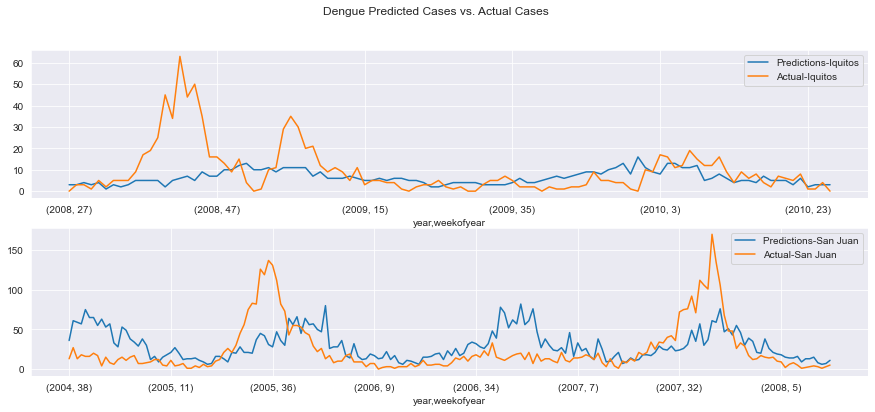

In [14]:
#Plotting the Results

figs, axes = plt.subplots(2,1, figsize=(15,6))

X_test_iq_plot = sm_test_iq.copy()
X_test_sj_plot = sm_test_sj.copy()

# plot iq
X_test_iq_plot['predictions'] = sm_predictions_iq
X_test_iq_plot.predictions.plot(ax=axes[0], label="Predictions-Iquitos")
y_test_iq = y_test_iq.sort_index(axis=0)
y_test_iq.plot(ax=axes[0], label="Actual-Iquitos")
axes[0].legend()

# plot sj
X_test_sj_plot['predictions'] = sm_predictions_sj
X_test_sj_plot.predictions.plot(ax=axes[1], label="Predictions-San Juan")
y_test_sj = y_test_sj.sort_index(axis=0)
y_test_sj.plot(ax=axes[1], label="Actual-San Juan")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
axes[1].legend()

In [15]:
#################################
# Fitting the Test Data Provided#
#################################

submission = pd.read_csv("submission_format.csv", index_col=[0, 1, 2])

X_submission_test_iq_sm, X_submission_test_sj_sm =  process(feat_df_path = 'dengue_features_test.csv',
                             labels_df_path= None,
                             standardize=True)

sj_predictions_sm = model_sj.predict(X_submission_test_sj_sm).astype(int)
iq_predictions_sm = model_iq.predict(X_submission_test_iq_sm).astype(int)

#Export it to CSV so we can get a score from DrivenData!
submission.total_cases = np.concatenate([sj_predictions_sm, iq_predictions_sm])
submission.to_csv("poisson_model_statsmodel2.csv")